# NN Difficulty evaluator

In [1]:
import numpy as np
import torch
from IPython.core.display import display
from matplotlib import pyplot as plt
from torch.optim import Adam

from evaluators import DirectEvaluator
from renderer import render_single_enemy
from shared_parameters import *
from utils import TrainUntil, MLP, save

*Suppose* we have an *oracle* that can correctly accurately evaluate the level difficulty.
Then we can train a neural network to learn from that oracle.

Here we use the `DirectEvaluator` as the oracle

In [2]:
oracle = DirectEvaluator(connector_length, np.deg2rad(max_angle), enemy_radius, bob_radius)

evaluator = MLP(1, 1, [8], activation="lrelu")
optim_evaluator = Adam(evaluator.parameters(), lr=0.001)

generator = MLP(1, 1, [8], activation="lrelu")
optim_generator = Adam(generator.parameters(), lr=0.01)

Now we generate a bunch of targets to train our nn evaluator


In [8]:
x = np.linspace(enemy_x_min, enemy_x_max, subdivisions)
difficulties = torch.from_numpy(oracle.evaluate(x)).to(torch.float32).unsqueeze(1)
states = torch.tensor([[x1] for x1 in x], dtype=torch.float32)

Display a random generated state

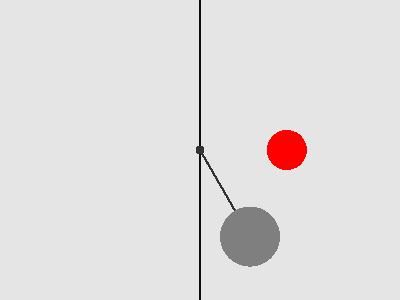

In [9]:
enemy_x = np.random.choice(x, 1).item()
image = render_single_enemy(enemy_x, resolution=0.5)

display(image)
save(image, "./data/example.png")

Difficulty evaluator training loop

10001 iterations to train estimator


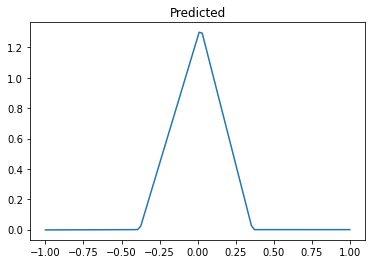

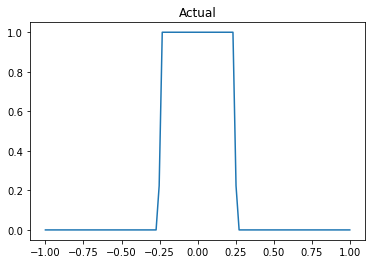

In [4]:
with TrainUntil(1e-5, 100, 10000) as trainer:
    while not trainer.done:
        predicted = evaluator(states)
        loss = ((predicted - difficulties) ** 2).mean()

        optim_evaluator.zero_grad()
        loss.backward()
        optim_evaluator.step()

        trainer.loss = loss

print(trainer.iteration, "iterations to train estimator")

axs = plt.subplot()
axs.plot(x, predicted.detach().numpy())
axs.set_title("Predicted")
plt.show()

axs = plt.subplot()
axs.plot(x, difficulties)
axs.set_title("Actual")
plt.show()


Now we can train the generator, in a fully differentiable way, using
the trained level difficulty evaluator.

In [5]:
batch_size = 100

with TrainUntil(0.01, 100, 10000) as trainer:
    while not trainer.done:
        d_in = torch.rand([batch_size, 1])
        states = generator(d_in)

        d_out = evaluator(states)

        loss = (d_in - d_out).abs().mean()

        optim_generator.zero_grad()
        loss.backward()
        optim_generator.step()

        trainer.loss = loss

print(trainer.iteration, loss.item())

5863 0.008489545434713364


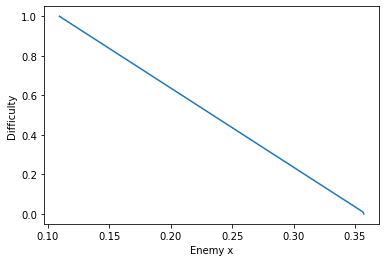

In [6]:
d_in = torch.linspace(0, 1, 100).unsqueeze(1)

with torch.no_grad():
    states = generator(d_in)

states = states.numpy()

axs = plt.subplot()
axs.plot(states, d_in)
axs.set_xlabel("Enemy x")
axs.set_ylabel("Difficulty")
plt.show()

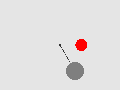

0.0

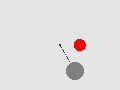

0.1111111119389534

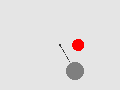

0.2222222238779068

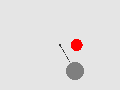

0.3333333432674408

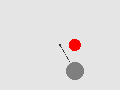

0.4444444477558136

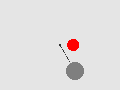

0.5555555820465088

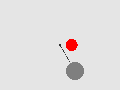

0.6666666269302368

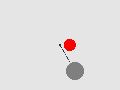

0.7777777910232544

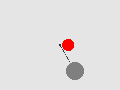

0.8888888955116272

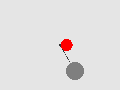

1.0

In [7]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    enemy_xs = generator(d_in)

images = [render_single_enemy(enemy_x, resolution=0.15) for enemy_x in enemy_xs]

for image, d in zip(images, d_in):
    display(image)
    display(d.item())